# Future Sales Predication

https://www.kaggle.com/c/competitive-data-science-predict-future-sales/overview

Challange: We are asking you to predict total sales for every product and store in the next month. 

In [1]:
#Imports
import pandas as pd
from matplotlib import pyplot as plt
from collections import Counter
import numpy as np
import seaborn as sns
import datetime as dt
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


In [2]:
#Loading all the files
item_categories = pd.read_csv('item_categories.csv')
items = pd.read_csv('items.csv')
sales_train = pd.read_csv('sales_train.csv')
sample_submission = pd.read_csv('sample_submission.csv')
shops = pd.read_csv('shops.csv')
test = pd.read_csv('test.csv')

# File descriptions
>sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.

>test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.

>sample_submission.csv - a sample submission file in the correct format.

>items.csv - supplemental information about the items/products.

>item_categories.csv  - supplemental information about the items categories.

>shops.csv- supplemental information about the shops.

# Data fields
>ID - an Id that represents a (Shop, Item) tuple within the test set

>shop_id - unique identifier of a shop

>item_id - unique identifier of a product

>item_category_id - unique identifier of item category

>item_cnt_day - number of products sold. You are predicting a monthly amount of this measure

>item_price - current price of an item

>date - date in format dd/mm/yyyy

>date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33

>item_name - name of item

>shop_name - name of shop

>item_category_name - name of item category

## Checking the size and shape of data before preprocessing and EDA.

In [3]:
#Checking the size and shape of data before preprocessing and EDA.
sales_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [4]:
item_categories
# we have 84 item catagories

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
...,...,...
79,Служебные,79
80,Служебные - Билеты,80
81,Чистые носители (шпиль),81
82,Чистые носители (штучные),82


In [5]:
items
# we have item id and the coresspondind item categeory id 
# NOTE: We dont care that much for the text features for this particular task. I will touch more on this a little later.

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62


In [6]:
shops
# Total of 60 shops

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


## lets check for any missing values

In [7]:
# lets check for any missing values
print('Mising values for sales_train')
print(sales_train.isnull().sum())
print('Mising values for item_categories')
print(item_categories.isnull().sum())
print('Mising values for items')
print(items.isnull().sum())
print('Mising values for shops')
print(shops.isnull().sum())


Mising values for sales_train
date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64
Mising values for item_categories
item_category_name    0
item_category_id      0
dtype: int64
Mising values for items
item_name           0
item_id             0
item_category_id    0
dtype: int64
Mising values for shops
shop_name    0
shop_id      0
dtype: int64


We dont have any missing values

## Now lets check for any outliers in the sales_train which is the main file.

/Users/hamza/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Item Price')

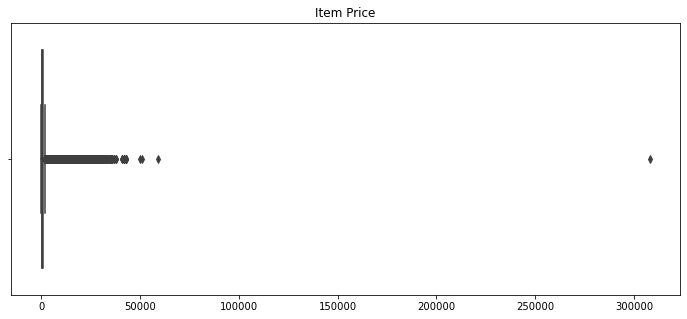

In [8]:
plt.figure(figsize=(12,5))
sns.boxplot(sales_train.item_price.values)
plt.title('Item Price')

/Users/hamza/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Item Count')

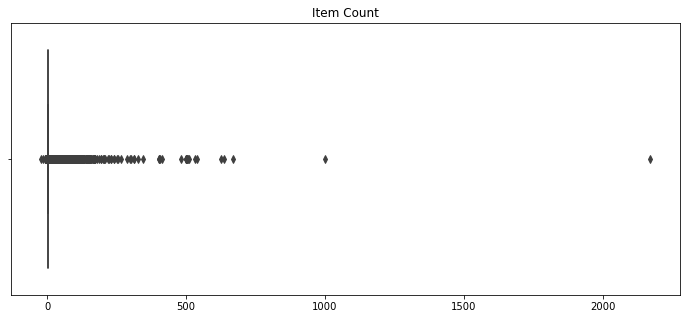

In [9]:
plt.figure(figsize=(12,5))
sns.boxplot(sales_train.item_cnt_day.values)
plt.title('Item Count')

We can definately see some outliers in both colums for a better result we will remove the outliers 

In [10]:
print('Lenth of sales_train before removing the outliers: ' + str(len(sales_train)))
sales_train_clean1 = sales_train.query('item_cnt_day >= 0 and item_cnt_day <= 1500 and item_price < 100000')
print('Lenth of sales_train after removing the outliers: ' + str(len(sales_train_clean1)))
print('The difference after removing the outliers is:' + str(2935849 - 2928492))


Lenth of sales_train before removing the outliers: 2935849
Lenth of sales_train after removing the outliers: 2928491
The difference after removing the outliers is:7357


/Users/hamza/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Item Price')

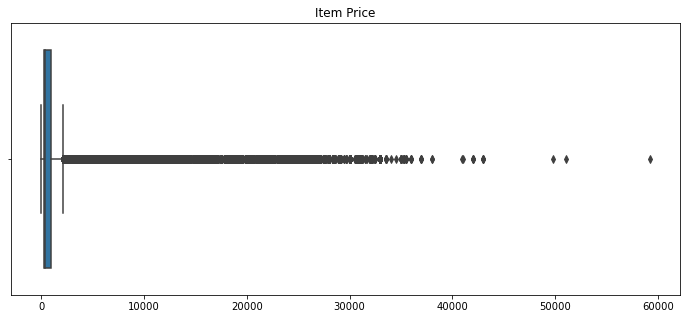

In [11]:
plt.figure(figsize=(12,5))
sns.boxplot(sales_train_clean1.item_price.values)
plt.title('Item Price')

/Users/hamza/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Item Count')

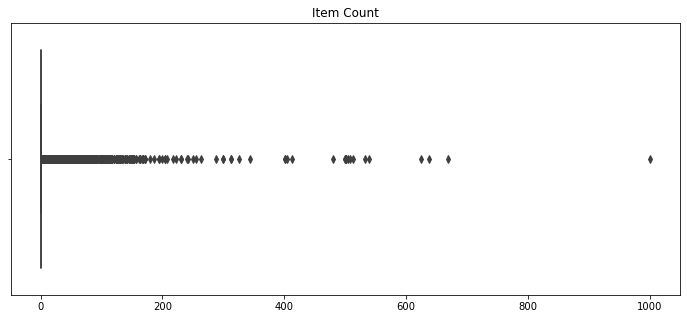

In [12]:
plt.figure(figsize=(12,5))
sns.boxplot(sales_train_clean1.item_cnt_day.values)
plt.title('Item Count')

As we can see from the above graphs the distribuation looks more uniform without any outliers. 

## Now we can do some EDA and get some insights on our dataset  

In [13]:
# just renaming the dataset.
train = sales_train_clean1

array([[<AxesSubplot:title={'center':'date_block_num'}>,
        <AxesSubplot:title={'center':'shop_id'}>],
       [<AxesSubplot:title={'center':'item_id'}>,
        <AxesSubplot:title={'center':'item_price'}>],
       [<AxesSubplot:title={'center':'item_cnt_day'}>, <AxesSubplot:>]],
      dtype=object)

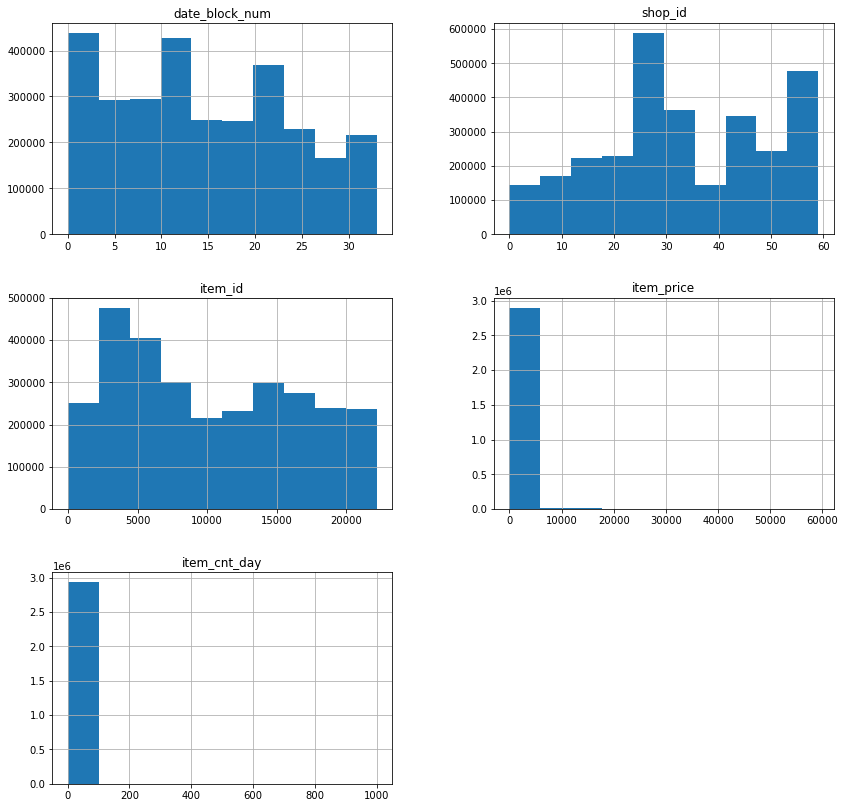

In [14]:
train.hist(figsize=(14, 14))

array([[<AxesSubplot:title={'center':'ID'}>,
        <AxesSubplot:title={'center':'shop_id'}>],
       [<AxesSubplot:title={'center':'item_id'}>, <AxesSubplot:>]],
      dtype=object)

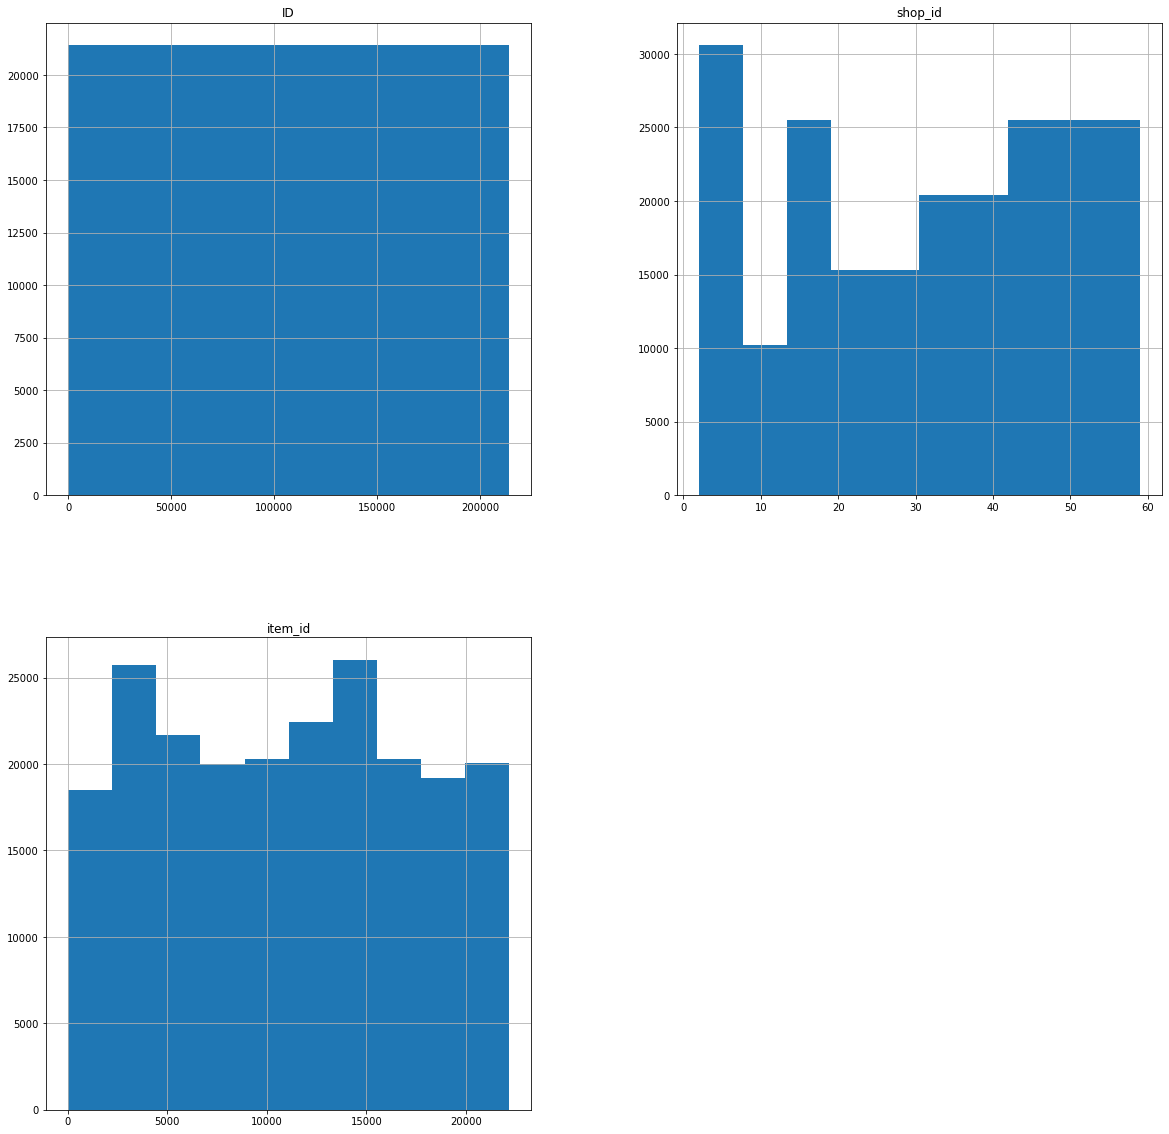

In [15]:
test.hist(figsize=(20, 20))

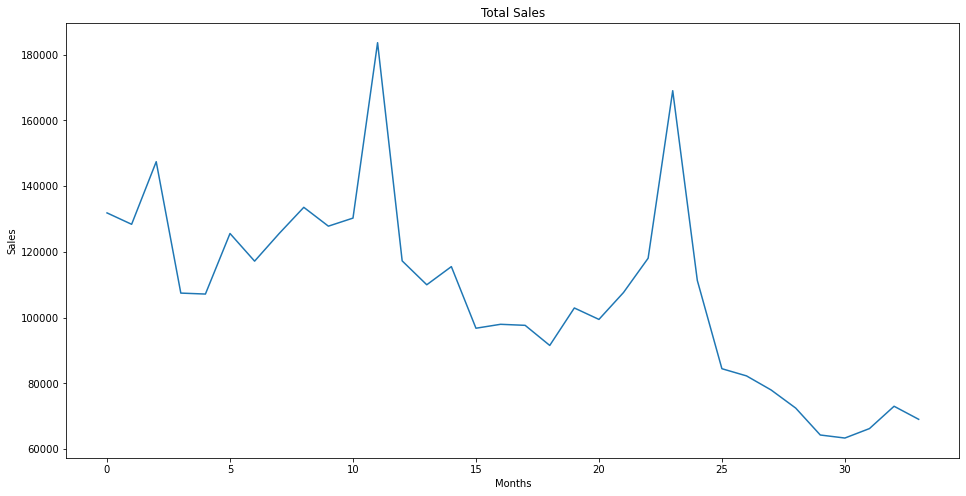

In [16]:
graph_data=train.groupby(["date_block_num"])["item_cnt_day"].sum()
graph_data.astype('float')
plt.figure(figsize=(16,8))
plt.title('Total Sales')
plt.xlabel('Months')
plt.ylabel('Sales')
plt.plot(graph_data);

## Now, we start merging all the files and do some feature engineering to create some more features that will help our model to be more accurate.

In [17]:
test_shop_ids = test['shop_id'].unique()
test_item_ids = test['item_id'].unique()

# Only shops that exist in test set.
train = train[train['shop_id'].isin(test_shop_ids)]

# Only items that exist in test set.
train = train[train['item_id'].isin(test_item_ids)]

In [18]:
# first we will change out date colum to pandas datetime format
# Note: We will only keep the year and month because we are only predicting the next month sales.  
train['date'] = pd.to_datetime(train['date'], format='%d.%m.%Y')
train['month'] = train['date'].dt.month
train['year'] = train['date'].dt.year
# drop date and item price we wont be using these features anymore
train = train.drop(['date','item_price'], axis=1)


# we will also add the cahnge item_cnt_day to item_cnt_month because we are predicting next month sales.
train = train.groupby([x for x in train.columns if x not in ['item_cnt_day']], as_index=False)[['item_cnt_day']].sum()
train = train.rename(columns={'item_cnt_day':'item_cnt_month'})

# now we can also add the monthly mean feature amd merge to out train dataset.
monthly_mean = train[['shop_id','item_id','item_cnt_month']].groupby(['shop_id','item_id'], as_index=False)[['item_cnt_month']].mean()
monthly_mean = monthly_mean.rename(columns={'item_cnt_month':'item_cnt_month_mean'})
train = pd.merge(train, monthly_mean, how='left', on=['shop_id','item_id'])

# now we add the previous month to each sample so our model can understand the trend better. And fill the empty celss with 0.
previous_month = train[train['date_block_num']==33][['shop_id','item_id','item_cnt_month']]
previous_month = previous_month.rename(columns={'item_cnt_month':'item_cnt_prev_month'})
train = pd.merge(train, previous_month, how='left', on=['shop_id','item_id']).fillna(0.)

# Now we can merge all the different files with train which will give us additional features  
train = pd.merge(train, items, how='left', on='item_id')
train = pd.merge(train, item_categories, how='left', on='item_category_id')
train = pd.merge(train, shops, how='left', on='shop_id')

In [19]:
train

,date_block_num,shop_id,item_id,month,year,item_cnt_month,item_cnt_month_mean,item_cnt_prev_month,item_name,item_category_id,item_category_name,shop_name
0,0,2,33,1,2013,1.0,1.100000,0.0,1+1 (BD),37,Кино - Blu-Ray,"Адыгея ТЦ ""Мега"""
1,0,2,482,1,2013,1.0,1.400000,0.0,1С:Бухгалтерия 8. Базовая версия,73,Программы - 1С:Предприятие 8,"Адыгея ТЦ ""Мега"""
2,0,2,491,1,2013,1.0,1.111111,0.0,1С:Деньги 8,73,Программы - 1С:Предприятие 8,"Адыгея ТЦ ""Мега"""
3,0,2,839,1,2013,1.0,1.111111,0.0,1С:Упрощенка 8,73,Программы - 1С:Предприятие 8,"Адыгея ТЦ ""Мега"""
4,0,2,1007,1,2013,3.0,1.428571,0.0,3D Crystal Puzzle Замок XL,67,Подарки - Развитие,"Адыгея ТЦ ""Мега"""
...,...,...,...,...,...,...,...,...,...,...,...,...
599907,33,59,22087,10,2015,6.0,6.424242,6.0,Элемент питания DURACELL LR03-BC2,83,Элементы питания,"Ярославль ТЦ ""Альтаир"""
599908,33,59,22088,10,2015,2.0,6.187500,2.0,Элемент питания DURACELL LR06-BC2,83,Элементы питания,"Ярославль ТЦ ""Альтаир"""
599909,33,59,22091,10,2015,1.0,2.294118,1.0,Элемент питания DURACELL TURBO LR 03 2*BL,83,Элементы питания,"Ярославль ТЦ ""Альтаир"""
599910,33,59,22100,10,2015,1.0,1.000000,1.0,Энциклопедия Adventure Time,42,"Книги - Артбуки, энциклопедии","Ярославль ТЦ ""Альтаир"""


## Feature Engineering

In [20]:
# adding shop_last_month_mean
grouped = train.groupby(['shop_id','date_block_num']).agg({'item_cnt_month':'mean'})
grouped.columns = ['shop_last_month_mean']
grouped.reset_index(inplace=True)
grouped['date_block_num']=grouped['date_block_num']+1
train = train.merge(grouped, on = ['shop_id','date_block_num'], how = 'left')
train['shop_last_month_mean'] = train['shop_last_month_mean'].fillna(0)

In [21]:
# adding item_last_month_mean
grouped = train.groupby(['item_id','date_block_num']).agg({'item_cnt_month':'mean'})
grouped.columns = ['item_last_month_mean']
grouped.reset_index(inplace=True)
grouped['date_block_num']=grouped['date_block_num']+1
train = train.merge(grouped, on = ['item_id','date_block_num'], how = 'left')
train['item_last_month_mean'] = train['item_last_month_mean'].fillna(0)

In [22]:
# adding category_last_month_mean
grouped = train.groupby(['item_category_id','date_block_num']).agg({'item_cnt_month':'mean'})
grouped.columns = ['category_last_month_mean']
grouped.reset_index(inplace=True)
grouped['date_block_num']=grouped['date_block_num']+1
train = train.merge(grouped, on=['item_category_id','date_block_num'],how='left')
train['category_last_month_mean'] = train['category_last_month_mean'].fillna(0)

In [23]:
# adding shop_3month_ago_mean
grouped = train.groupby(['shop_id','date_block_num']).agg({'item_cnt_month':'mean'})
grouped.columns = ['shop_3month_ago_mean']
grouped.reset_index(inplace=True)
grouped['date_block_num']=grouped['date_block_num']+3
train = train.merge(grouped, on = ['shop_id','date_block_num'], how = 'left')
train['shop_3month_ago_mean'] = train['shop_3month_ago_mean'].fillna(0)

In [24]:
# adding item_3month_ago_mean
grouped = train.groupby(['item_id','date_block_num']).agg({'item_cnt_month':'mean'})
grouped.columns = ['item_3month_ago_mean']
grouped.reset_index(inplace=True)
grouped['date_block_num']=grouped['date_block_num']+3
train = train.merge(grouped, on = ['item_id','date_block_num'], how = 'left')
train['item_3month_ago_mean'] = train['item_3month_ago_mean'].fillna(0)


In [25]:
# adding category_3month_ago_mean
grouped = train.groupby(['item_category_id','date_block_num']).agg({'item_cnt_month':'mean'})
grouped.columns = ['category_3month_ago_mean']
grouped.reset_index(inplace=True)
grouped['date_block_num']=grouped['date_block_num']+3
train = train.merge(grouped, on=['item_category_id','date_block_num'],how='left')
train['category_3month_ago_mean'] = train['category_3month_ago_mean'].fillna(0)

In [26]:
train

,date_block_num,shop_id,item_id,month,year,item_cnt_month,item_cnt_month_mean,item_cnt_prev_month,item_name,item_category_id,item_category_name,shop_name,shop_last_month_mean,item_last_month_mean,category_last_month_mean,shop_3month_ago_mean,item_3month_ago_mean,category_3month_ago_mean
0,0,2,33,1,2013,1.0,1.100000,0.0,1+1 (BD),37,Кино - Blu-Ray,"Адыгея ТЦ ""Мега""",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0,2,482,1,2013,1.0,1.400000,0.0,1С:Бухгалтерия 8. Базовая версия,73,Программы - 1С:Предприятие 8,"Адыгея ТЦ ""Мега""",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0,2,491,1,2013,1.0,1.111111,0.0,1С:Деньги 8,73,Программы - 1С:Предприятие 8,"Адыгея ТЦ ""Мега""",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0,2,839,1,2013,1.0,1.111111,0.0,1С:Упрощенка 8,73,Программы - 1С:Предприятие 8,"Адыгея ТЦ ""Мега""",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0,2,1007,1,2013,3.0,1.428571,0.0,3D Crystal Puzzle Замок XL,67,Подарки - Развитие,"Адыгея ТЦ ""Мега""",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599907,33,59,22087,10,2015,6.0,6.424242,6.0,Элемент питания DURACELL LR03-BC2,83,Элементы питания,"Ярославль ТЦ ""Альтаир""",1.885714,2.440000,2.865979,1.734893,3.000000,3.298851
599908,33,59,22088,10,2015,2.0,6.187500,2.0,Элемент питания DURACELL LR06-BC2,83,Элементы питания,"Ярославль ТЦ ""Альтаир""",1.885714,3.823529,2.865979,1.734893,4.758621,3.298851
599909,33,59,22091,10,2015,1.0,2.294118,1.0,Элемент питания DURACELL TURBO LR 03 2*BL,83,Элементы питания,"Ярославль ТЦ ""Альтаир""",1.885714,2.047619,2.865979,1.734893,2.416667,3.298851
599910,33,59,22100,10,2015,1.0,1.000000,1.0,Энциклопедия Adventure Time,42,"Книги - Артбуки, энциклопедии","Ярославль ТЦ ""Альтаир""",1.885714,3.032258,3.323944,1.734893,1.571429,2.838509


In [27]:
# Now we will drop the text features as we dont need them.
train.drop(['item_name', 'item_category_name','shop_name'], axis='columns', inplace=True)
train



,date_block_num,shop_id,item_id,month,year,item_cnt_month,item_cnt_month_mean,item_cnt_prev_month,item_category_id,shop_last_month_mean,item_last_month_mean,category_last_month_mean,shop_3month_ago_mean,item_3month_ago_mean,category_3month_ago_mean
0,0,2,33,1,2013,1.0,1.100000,0.0,37,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0,2,482,1,2013,1.0,1.400000,0.0,73,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0,2,491,1,2013,1.0,1.111111,0.0,73,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0,2,839,1,2013,1.0,1.111111,0.0,73,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0,2,1007,1,2013,3.0,1.428571,0.0,67,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599907,33,59,22087,10,2015,6.0,6.424242,6.0,83,1.885714,2.440000,2.865979,1.734893,3.000000,3.298851
599908,33,59,22088,10,2015,2.0,6.187500,2.0,83,1.885714,3.823529,2.865979,1.734893,4.758621,3.298851
599909,33,59,22091,10,2015,1.0,2.294118,1.0,83,1.885714,2.047619,2.865979,1.734893,2.416667,3.298851
599910,33,59,22100,10,2015,1.0,1.000000,1.0,42,1.885714,3.032258,3.323944,1.734893,1.571429,2.838509


In [28]:
# Getting all the features names.
feature_list = [c for c in train.columns if c not in 'item_cnt_month']
# 32 months for train
X_train = train[train['date_block_num'] < 33]
y_train = X_train['item_cnt_month'].clip(0., 20.)
X_train = X_train[feature_list]
# 33rd month by iteselt for validation
X_val = train[train['date_block_num'] == 33]
y_val = X_val['item_cnt_month'].clip(0., 20.)
X_val = X_val[feature_list]


## Now, we can train our model on Random Forest Regressor

In [29]:
randomforest_reg=RandomForestRegressor(n_estimators=400, max_depth= 20, min_samples_split=6,random_state=42, n_jobs=-1, verbose=1)

In [30]:
t1=dt.datetime.now()
randomforest_reg.fit(X_train, y_train)
print(dt.datetime.now() - t1)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.6min


0:03:39.890959


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  3.7min finished


In [31]:
y_pred=randomforest_reg.predict(X_val)
RMSE_val=np.sqrt(mean_squared_error(y_val, y_pred))


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 400 out of 400 | elapsed:    0.3s finished


In [32]:
print("RMSE: %f" % (RMSE_val))

RMSE: 1.309064


## We will use another famous algorithmn to see if we get any good results. 
## The algorithmn we will use is called XGBoost

In [33]:
import xgboost as xgb

In [34]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 10, alpha = 10, n_estimators = 400)

In [35]:
data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)

In [48]:
t2=dt.datetime.now()
history = xg_reg.fit(X_train,y_train)
print(dt.datetime.now() - t2)

[21:14:26] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:11] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
{}
0:00:45.448179


In [37]:
preds = xg_reg.predict(X_val)

In [38]:
rmse = np.sqrt(mean_squared_error(y_val, preds))
print("RMSE: %f" % (rmse))

RMSE: 1.378975


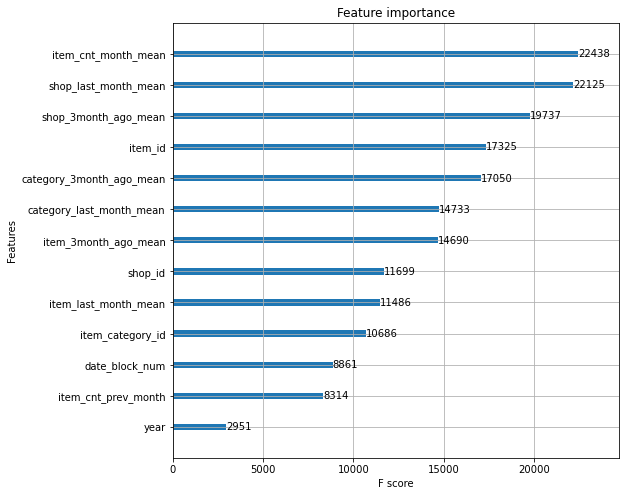

In [51]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [6, 6]
plt.show()